## About this File
- Purely EDA
- No modeling
- Looking for insights
- Will save a csv for any set I intend to model to be opened in a separate notebook

### Note to self:
- this project is holding artist constant
- meaning, we wont factor in how many followers the artist of a given song has in our predictions
- I want to see a model based purely off the music within the song itself, and not have any kind of artist loyalty factored in


## EDA for Dataset

In [1]:
# Import some libraries that will be used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

import sys
sys.path.insert(1, '/Users/brianmccabe/DataScience/Flatiron/mod3/Spotify/scripts/')
import config


pd.set_option('display.max_columns', 300)

%matplotlib inline

#### Establish connection to mysql database where I stored the data I gathered

In [2]:
connection = mysql.connector.connect(host=config.host,
                                         user=config.user,
                                         port=config.port,
                                         password=config.password,
                                         database=config.database,
                                         auth_plugin='mysql_native_password')


In [3]:
cursor = connection.cursor()
query = "SELECT * FROM Songs"

In [4]:
df = pd.read_sql(query, connection)

In [5]:
# Inspect the head of data
df.head()

,id,song_id,song_name,danceability,energy,musical_key,loudness,musical_mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,num_sections,explicit,popular
0,1,3CLgjFr8F0g8q4JD6OYOPK,8896,0.456,0.374,7,-13.026,1,0.1670,0.835,0.02600,0.2610,0.1690,169.595,263151,4,8,0,0
1,2,1KeHN4mY3rIAbQJa8zLOCY,Brownlow,0.429,0.284,11,-10.750,1,0.0823,0.695,0.42700,0.2500,0.1120,104.429,261219,4,10,0,0
2,3,0qzqk0Cu9mcMwSpYgHiueK,Falling Short (2014),0.753,0.292,9,-11.866,0,0.0450,0.754,0.00030,0.1140,0.1060,124.679,209692,4,8,0,0
3,4,0KKJdRXJqpiU5nnjJ5SoQo,Dancing,0.366,0.258,0,-13.214,1,0.0751,0.940,0.00225,0.1700,0.0381,61.651,216705,4,9,0,0
4,5,1Ser4X0TKttOvo8bgdytTP,Come Get Her,0.689,0.564,2,-6.226,1,0.1360,0.187,0.00000,0.0721,0.1230,185.023,212947,4,12,1,1


In [6]:
# Check info of dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11798 entries, 0 to 11797
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                11798 non-null  int64  
 1   song_id           11798 non-null  object 
 2   song_name         11798 non-null  object 
 3   danceability      11798 non-null  float64
 4   energy            11798 non-null  float64
 5   musical_key       11798 non-null  int64  
 6   loudness          11798 non-null  float64
 7   musical_mode      11798 non-null  int64  
 8   speechiness       11798 non-null  float64
 9   acousticness      11798 non-null  float64
 10  instrumentalness  11798 non-null  float64
 11  liveness          11798 non-null  float64
 12  valence           11798 non-null  float64
 13  tempo             11798 non-null  float64
 14  duration_ms       11798 non-null  int64  
 15  time_signature    11798 non-null  int64  
 16  num_sections      11798 non-null  int64 

In [7]:
# No non nulls after reading in from spotify and pulling from mysql
(df.isna().sum() > 0).any()

False

#### Get a quick snapshot of distributions using pairplot

In [8]:
cols = ['danceability', 'energy', 'musical_key',
       'loudness', 'musical_mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'time_signature', 'num_sections', 'explicit', 'popular']

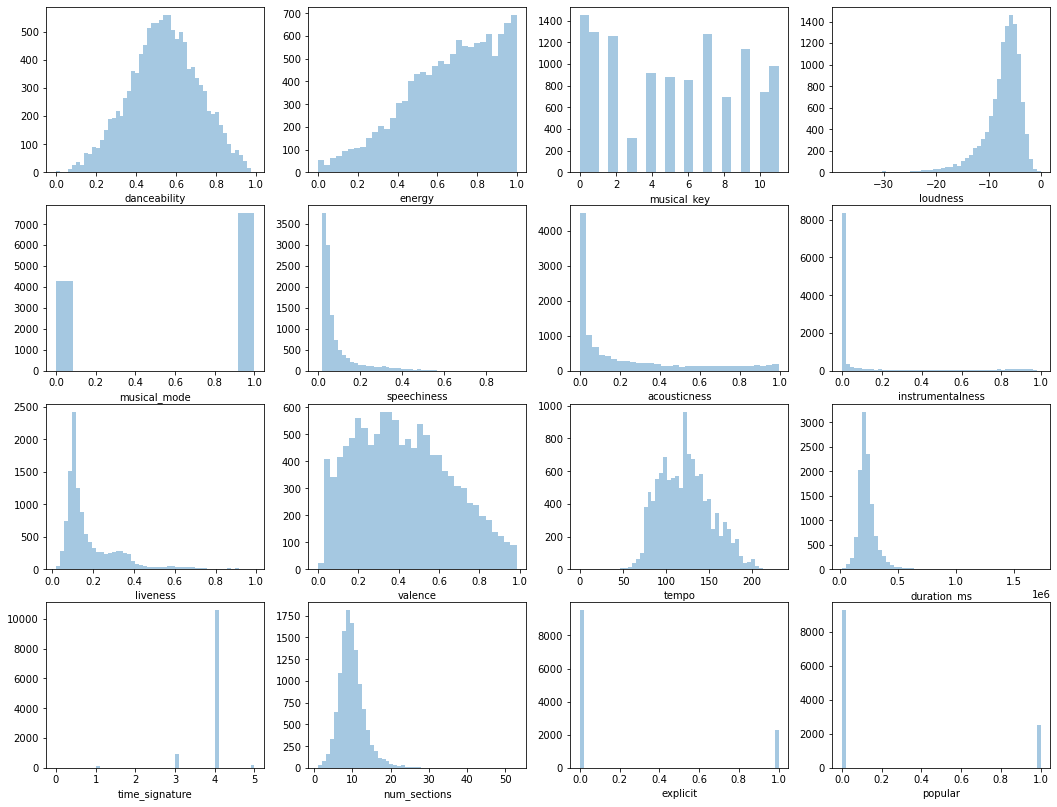

In [9]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(18,14))

for i in range(0,16):
    sns.distplot(df[cols[i]], ax=axes[i//4][i%4], kde = False)


##### It appears our target variable has class imbalance which will need to be addressed, let's see how much

In [10]:
df.popular.value_counts()

0    9260
1    2538
Name: popular, dtype: int64

##### Check correlation matrix for any multicolinearity issues

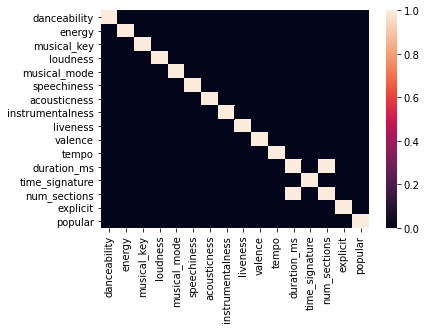

In [11]:
sns.heatmap(df.iloc[:,1:].corr() > .8)

It appears there is a large multicolinearity between num_sections and duration_ms, which makes sense. However, I do believe that they both are important, since there can be a short song with lots of sections. Before removing one, I want to feature engineer a new column to capture this info somehow.

### Engineer a new feature to capture duration per number of sections

In [12]:
df['duration_per_num_sections'] = df.duration_ms / df.num_sections

In [13]:
# Drop either duration or num_sections now, whichever has less correlation with the target variable
df[['popular', 'duration_ms', 'num_sections', 'duration_per_num_sections']].corr()

,popular,duration_ms,num_sections,duration_per_num_sections
popular,1.000000,-0.083681,-0.056405,-0.041961
duration_ms,-0.083681,1.000000,0.811471,0.230649
num_sections,-0.056405,0.811471,1.000000,-0.319101
duration_per_num_sections,-0.041961,0.230649,-0.319101,1.000000


Our newly engineered column, duration/num_sections has similar correlation to the target variable as num_sections, but does not have a super large multicolinearity with duration_ms. Since duration_ms has a large magnitude of correlation with our target, I will choose to remove "num_sections" based on its multicolinearity issue and worse correlation with our target.

In [14]:
df.drop('num_sections', axis=1, inplace=True)

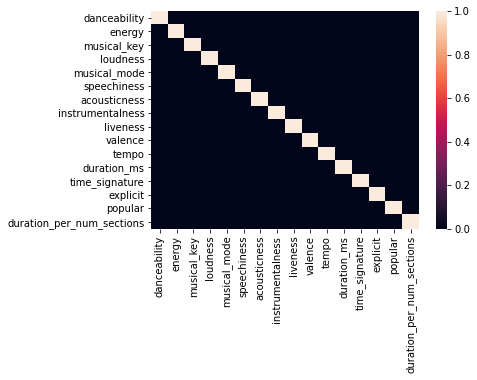

In [15]:
sns.heatmap(df.iloc[:,1:].corr() > .8)

Our heatmap now indicates that there are no blantant issues with multicolinearity in our data (on the assumption that a score > .8 warrants removal)

### Get Dummies for Categorical Features

In [16]:
# musical_key encoding
keys = pd.get_dummies(df.musical_key, prefix='key_', drop_first=True)
df = pd.concat([df.drop('musical_key', axis=1), keys], axis=1)

In [17]:
# time_signature encoding
sigs = pd.get_dummies(df.time_signature, prefix='time_sig_', drop_first=True)
df = pd.concat([df.drop('time_signature', axis=1), sigs], axis=1)

### Drop Features Irrelevant to Modeling

In [18]:
df.drop(['id', 'song_id', 'song_name'], inplace=True, axis=1)

In [19]:
df.head()

,danceability,energy,loudness,musical_mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,explicit,popular,duration_per_num_sections,key__1,key__2,key__3,key__4,key__5,key__6,key__7,key__8,key__9,key__10,key__11,time_sig__1,time_sig__3,time_sig__4,time_sig__5
0,0.456,0.374,-13.026,1,0.1670,0.835,0.02600,0.2610,0.1690,169.595,263151,0,0,32893.875000,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
1,0.429,0.284,-10.750,1,0.0823,0.695,0.42700,0.2500,0.1120,104.429,261219,0,0,26121.900000,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2,0.753,0.292,-11.866,0,0.0450,0.754,0.00030,0.1140,0.1060,124.679,209692,0,0,26211.500000,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,0.366,0.258,-13.214,1,0.0751,0.940,0.00225,0.1700,0.0381,61.651,216705,0,0,24078.333333,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0.689,0.564,-6.226,1,0.1360,0.187,0.00000,0.0721,0.1230,185.023,212947,1,1,17745.583333,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0


## Important Notes
- Genre is not released for each song, however, genre of a song would greatly affect a model. For instance, rap songs and instrumental songs likely have very different predictors as to what dictates a popular song. 
- Because, at this point in time in my course I have not been introduced to unsupervised clustering, I won't be able to model myself some machine learned genres
- Thus, I will create 2 models for this project, based off genres that are easy to assume from spotify features. (1) A model for rap songs. Spotify API indicates that speechiness values over .22 strongly indicate rap, and so I will use this to create my rap set. (2) I will create a set for purely instrumental songs, meaning no lyrics. Spotify indicates that instrumental values over .5 represent purely instrumental songs.
- Another feature I will hold constant is release date. Popularity can be influenced by how old a song is, and to combat this I only pulled songs from the past few years. This will add some degree of error to my model, so this would be something to improve upon in a future project.

# Modeling

## Rap Model

In [20]:
rap_df = df[df.speechiness >= .22]

In [21]:
# Check class imbalance in this subset
rap_df.popular.value_counts()

0    771
1    416
Name: popular, dtype: int64

In [22]:
rap_df.head()

,danceability,energy,loudness,musical_mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,explicit,popular,duration_per_num_sections,key__1,key__2,key__3,key__4,key__5,key__6,key__7,key__8,key__9,key__10,key__11,time_sig__1,time_sig__3,time_sig__4,time_sig__5
44,0.320,0.934,-4.363,0,0.246,0.13400,0.000000,0.0925,0.495,138.982,196476,0,0,21830.666667,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
55,0.282,0.579,-12.653,0,0.380,0.05240,0.000812,0.0977,0.205,178.866,386556,0,0,20345.052632,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
80,0.548,0.724,-6.681,0,0.275,0.39000,0.000000,0.4690,0.481,110.066,516000,1,0,25800.000000,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
82,0.735,0.890,-4.886,0,0.252,0.14800,0.000000,0.3140,0.565,122.014,572547,1,0,28627.350000,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
85,0.713,0.883,-5.407,0,0.265,0.00588,0.000020,0.7240,0.452,124.967,338627,1,0,19919.235294,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0


In [28]:
cols = ['danceability', 'energy', 
       'loudness', 'musical_mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
        'explicit', 'popular']

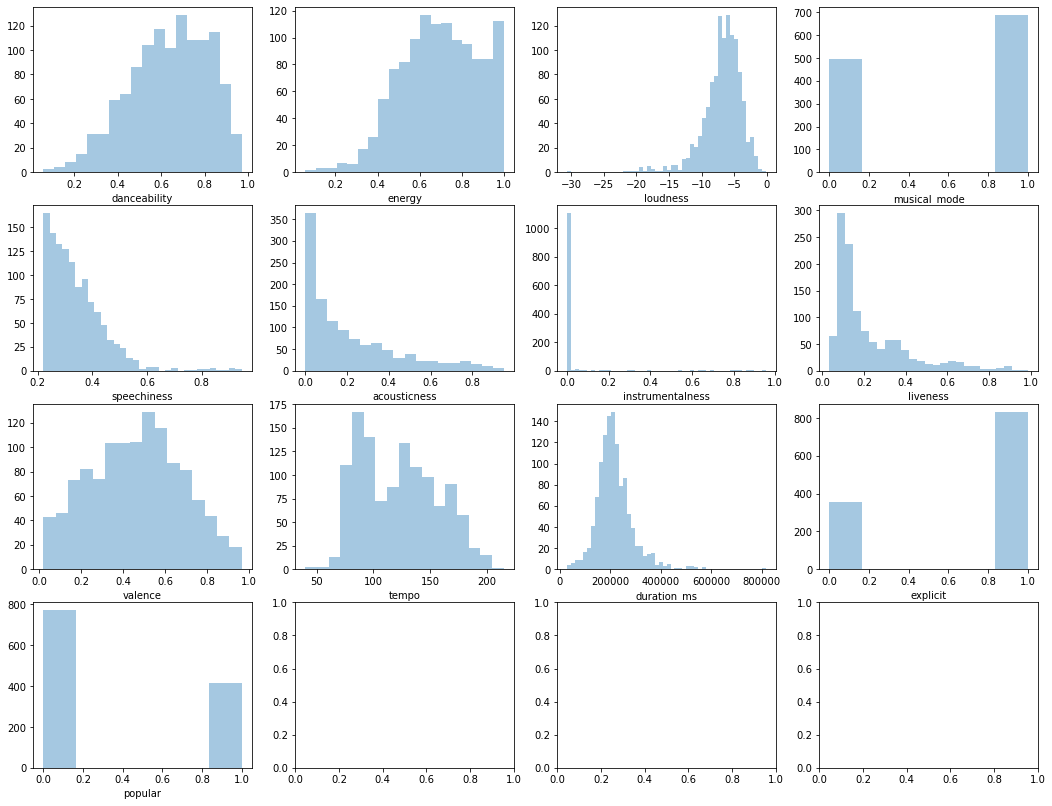

In [30]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(18,14))

for i in range(0,13):
    sns.distplot(rap_df[cols[i]], ax=axes[i//4][i%4], kde = False)

In [31]:
rap_df.instrumentalness.describe()

count    1187.000000
mean        0.029425
std         0.136153
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000017
max         0.955000
Name: instrumentalness, dtype: float64

In [32]:
inst_checks = [.1, .01, .001, .0005, .0001, .00001, 0]
for check in inst_checks:
    print(len(rap_df[rap_df.instrumentalness <= check].instrumentalness), "Less than instrumental value: " +  str(check))

1125 Less than instrumental value: 0.1
1089 Less than instrumental value: 0.01
1030 Less than instrumental value: 0.001
1015 Less than instrumental value: 0.0005
959 Less than instrumental value: 0.0001
854 Less than instrumental value: 1e-05
748 Less than instrumental value: 0


Some rap songs are obviously more iinstrumental than others, but based on the value counts shown above, the vast majority of our set has instrumental values under .0005. Beyond that, a majority of them do not even have instruments at all, indicated by the large number of 0s in the column. Instead of trying to fix a distribution that is beyond heavily skewed, I will instead feature engineer a new column indicating the presence of instruments in the song.

#### Engineer a new feature indicating presence of instrument


In [33]:
rap_df['no_instruments'] = np.where(rap_df.instrumentalness == 0, 1, 0)

# ignore the warning, the code went through...

<ipython-input-33-5e1db5dc92eb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rap_df['no_instruments'] = np.where(rap_df.instrumentalness == 0, 1, 0)


In [34]:
rap_df.no_instruments.value_counts()

1    748
0    439
Name: no_instruments, dtype: int64

In [35]:
cols = list(rap_df.columns)

In [36]:
cols.remove('popular')

In [37]:
len(cols)

29

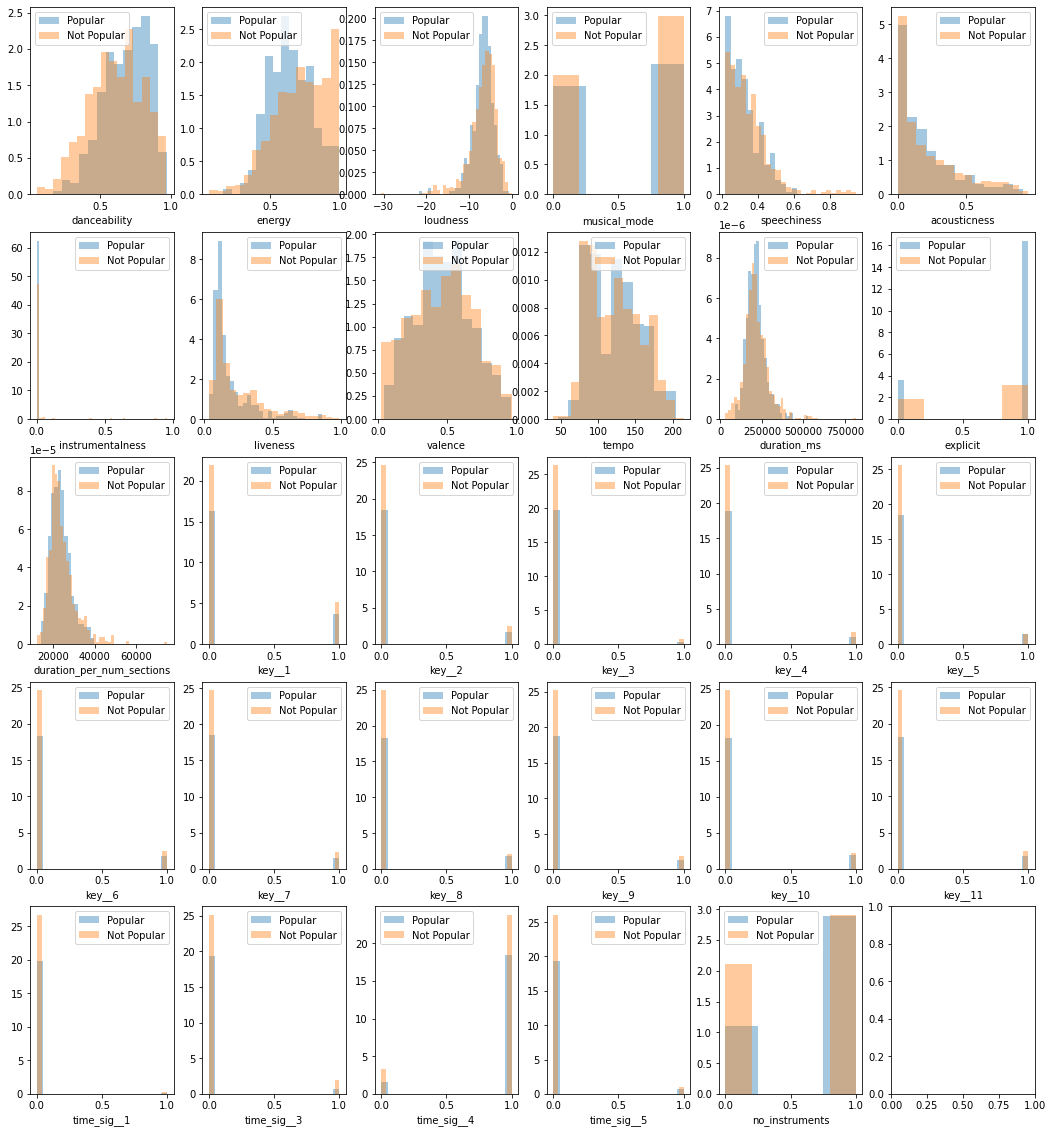

In [38]:
fig, axes = plt.subplots(nrows=5, ncols=6, figsize=(18,20))

for i in range(0,29):
    sns.distplot(rap_df[rap_df.popular == 1][cols[i]], ax=axes[i//6][i%6], kde = False, 
                label = 'Popular', norm_hist=True)
    sns.distplot(rap_df[rap_df.popular == 0][cols[i]], ax=axes[i//6][i%6], kde = False, 
                 label = 'Not Popular', norm_hist=True)
    axes[i//6][i%6].legend()

It looks like, for rap songs, danceability, energy, and explicit have strong correlations with our predictor variable. Let's check the correlations next.

In [39]:
# Get 10 most influential
most_correlated_pos = rap_df.corr().loc['popular', :].sort_values(ascending=False)[1:6] # ignore pop corr with self
most_correlated_neg = rap_df.corr().loc['popular', :].sort_values(ascending=True)[0:5] 
corrs = pd.concat([pd.DataFrame(most_correlated_pos), pd.DataFrame(most_correlated_neg)])
corrs.reset_index(inplace=True)
corrs.columns = ['feature', 'corr']
corrs = corrs.sort_values(by = 'corr')
corrs

,feature,corr
5,energy,-0.197779
6,liveness,-0.161780
7,instrumentalness,-0.131229
8,speechiness,-0.100275
9,time_sig__3,-0.076836
4,key__5,0.039808
3,time_sig__4,0.069696
2,no_instruments,0.142109
1,explicit,0.193232
0,danceability,0.195803


Text(0, 0.5, '')

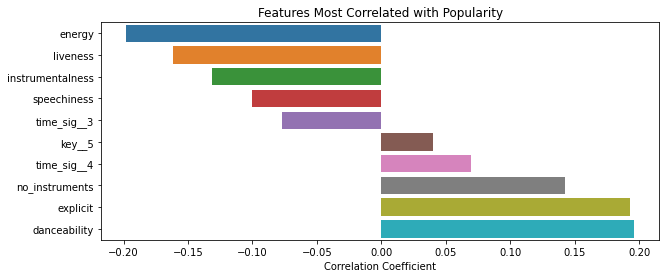

In [40]:
plt.figure(figsize=(10,4))
sns.barplot(x='corr', y='feature', data=corrs)
plt.title('Features Most Correlated with Popularity')
plt.xlabel('Correlation Coefficient')
plt.ylabel('')

While certainly insightful, I would like to now save the rap_df in a csv and then open it up in a new notebook to apply several models to it to try and find the best one.

In [41]:
rap_df.to_csv("rap_df.csv")

## Instrumental Model

In [85]:
inst_df = df[df.instrumentalness >= .5]

In [184]:
# Check class imbalance in this subset
inst_df.popular.value_counts()

0    1401
1     137
Name: popular, dtype: int64